In [68]:
# Loading packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce

In [18]:
# Loading raw data 
recipes_raw = pd.read_parquet("../data/recipes.parquet")
recipes_raw['RecipeId'] = recipes_raw['RecipeId'].astype(int)
recipes_raw.set_index('RecipeId', inplace=True)

reviews_raw = pd.read_parquet("../data/reviews.parquet")
reviews_raw.set_index('ReviewId', inplace=True)

In [69]:
# Retrieving only clean data 
# TODO In the future do the same but using all of the columns that have been cleaned. Not only mine (Felix's)

# Retrieving parquet files with clean columns
continuous_attr = pd.read_parquet("../data/clean_columns/continuous_attr_clean.parquet")
cook_times = pd.read_parquet("../data/clean_columns/cooktimesclean.parquet")
main_ingredients = pd.read_parquet("../data/clean_columns/main_ingredients_clean.parquet")
meal_types = pd.read_parquet("../data/clean_columns/mealtype_clean.parquet")
baking = pd.read_parquet("../data/clean_columns/baking.parquet")

# Retrieving pickle files with clean columns
regions = pd.read_pickle("../data/clean_columns/regiondatav0.pk")
appliances = pd.read_pickle("../data/clean_columns/appliance_clean.pk")



regions

# # Assuming dfs is a list containing your 10 DataFrames
# dfs = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10]  # Replace with your actual DataFrames

# # Perform inner join on all DataFrames
# result_df = reduce(lambda left, right: pd.merge(left, right, on='index', how='inner'), dfs)

# print(result_df)


,Name,RegionKeywords,Continents,Regions
RecipeId,,,,
49,chicken breasts lombardi,"[italian, european]",[european],[italian]
55,betty crocker's southwestern guacamole dip,"[southwestern u.s., mexican]",[north american],"[southwestern u.s., mexican]"
58,low-fat burgundy beef & vegetable stew,[french],[european],[french]
59,lou's fabulous bruschetta,"[italian, european]",[european],[italian]
62,"black bean, corn, and tomato salad",[polish],[european],[polish]
...,...,...,...,...
539115,dutch fried potatoes (gebakken aardappelen),"[dutch, european]",[european],[dutch]
539152,stir fried noodles (mie goreng),"[indonesian, asian, dutch, european]","[asian, european]","[indonesian, dutch]"
539182,cinnamony sweet moroccan orange salad,"[moroccan, african]",[african],[moroccan]


In [ ]:
import pandas as pd

def left_join_multiple_dfs_by_index(df_base, dfs_list):
  """
  Performs a left join on a base dataframe with multiple dataframes using indexes.

  Args:
      df_base: The base dataframe to left-join with.
      dfs_list: A list of dataframes to be left-joined with df_base.

  Returns:
      A new dataframe resulting from the left join operation.
  """

  # Set base dataframe index for efficient joining
  df_base = df_base.set_index('join_col')  # Replace 'join_col' if needed

  result = df_base

  for df in dfs_list:
    # Ensure indexes are set and compatible
    if not df.index.name == 'join_col':
      df = df.set_index('join_col')  # Replace 'join_col' if needed
    if not df.index.dtype == df_base.index.dtype:
      raise ValueError("Dataframe indexes must have compatible data types")
    result = result.join(df, how='left', sort=False)  # Avoid unnecessary sorting

  return result.reset_index()  # Reset index for easier use

# Example usage (replace with your actual dataframes)
df_base = pd.DataFrame({'data': ['a', 'b', 'c']}, index=[1, 2, 3])
df_a = pd.DataFrame({'data_a': ['x', 'y']}, index=[1, 4])
df_b = pd.DataFrame({'data_b': [10, 20]}, index=[2, 5])
df_j = pd.DataFrame({'data_j': ['z', None]}, index=[3, 6])  # Include None to test handling

dfs_list = [df_a, df_b, df_j]

joined_df = left_join_multiple_dfs_by_index(df_base.copy(), dfs_list)
print(joined_df)


### Understanding the `AgregatedRating` and `ReviewCount` columns.

First we check the integrity of the `AgregatedRating` and `ReviewCount` columns. This is to make sure we understand what they are. To do so, we will create new columns called `Rating_avg` and `Review_count` that will compute the average rating and review count per recipe. Then we compare `AgregatedRating` vs `Rating_avg` and `ReviewCount` vs `Review_count` so see if they are actually very different or not. If not, we can conlude that it is okat to use the `AgregatedRating` and `ReviewCount` columns.

In [55]:
# We retrieve the `Rating_avg` and `Review_count` from the reviews dataframe
aggregate_data = reviews_raw.groupby('RecipeId')['Rating'].agg(Rating_avg='mean', Review_count='count').round(2)
aggregate_data 

recipes_comparison = pd.merge(recipes_raw, aggregate_data, left_index=True, right_index=True, how='left')

print("The following is the number of recipes that has null values in the respective column.\n")
print(recipes_comparison[['AggregatedRating', 'ReviewCount', 'Rating_avg', 'Review_count']].isnull().sum())

The following is the number of recipes that has null values in the respective column.

AggregatedRating    253223
ReviewCount         247489
Rating_avg          250843
Review_count        250843
dtype: int64


Analyzing the difference between `AggregatedRating` and `Rating_avg` columns.

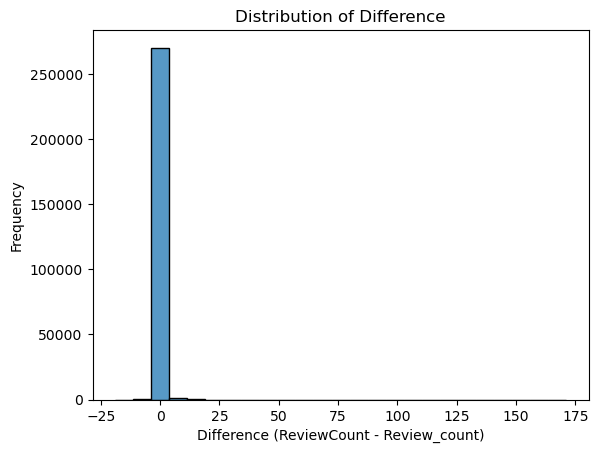

Only 0.157% of the recipes have a difference > 4 between ReviewCount and Review_count


In [67]:
recipes_comparison['Difference'] = recipes_comparison['ReviewCount'] - recipes_comparison['Review_count']

sns.histplot(data=recipes_comparison, x='Difference', bins=25)
plt.xlabel('Difference (ReviewCount - Review_count)')
plt.ylabel('Frequency')
plt.title('Distribution of Difference')
plt.show()

percentage = 100 * (len(recipes_comparison[abs(recipes_comparison['Difference'] > 4)]) / len(recipes_comparison))
print(f"Only {round(percentage, 3)}% of the recipes have a difference > 4 between ReviewCount and Review_count")


Analyzing the difference between `ReviewCount` and `Review_count` columns.

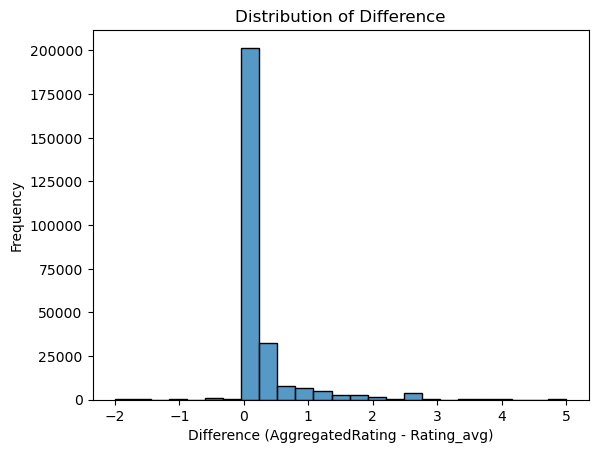

Only 3.098% of the recipes have a difference > 1 between AggregatedRating and Rating_avg


In [52]:
recipes_comparison['Difference'] = recipes_comparison['AggregatedRating'] - recipes_comparison['Rating_avg']

sns.histplot(data=recipes_comparison, x='Difference', bins=25)
plt.xlabel('Difference (AggregatedRating - Rating_avg)')
plt.ylabel('Frequency')
plt.title('Distribution of Difference')
plt.show()

percentage = 100 * (len(recipes_comparison[abs(recipes_comparison['Difference'] > 1)]) / len(recipes_comparison))
print(f"Only {round(percentage, 3)}% of the recipes have a difference > 1 between AggregatedRating and Rating_avg")

We can conclude that both the `AgregatedRating` and `ReviewCount` columns are okay to use as they are. They only thing that needs to be decided is whether we will use either of this two columns for our model. This will be discussed in our Google Doc.